# Project 2: Advanced Lane Line Detection

1. [Camera Calibration](#camera_cal)<br>
2. [Perspective Transformation](#perspective_trans)
3. [Color and Gradient Thresholding](#color_grad_thresh)
4. [Fitting Polynomial Curves](#fit_poly)

<a id='camera_cal'></a>
## Camera Calibration
Before moving on to detecting lane lines, we need to calibrate our camera using the provided checkerboard images and OpenCV

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# We can produce a list of camera calibration image names like so
cal_images = os.listdir('camera_cal/')
print("Number of calibration images: ", len(cal_images))
cal_images[:5]

Number of calibration images:  20


['calibration1.jpg',
 'calibration10.jpg',
 'calibration11.jpg',
 'calibration12.jpg',
 'calibration13.jpg']

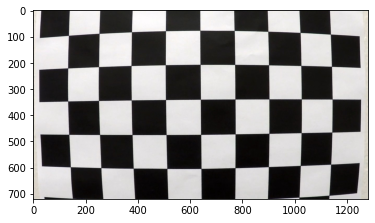

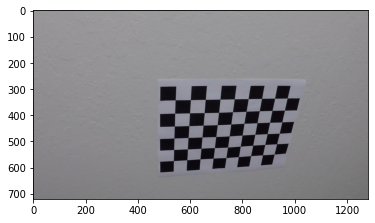

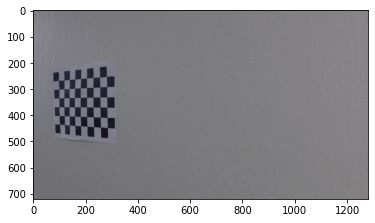

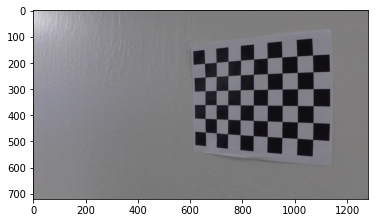

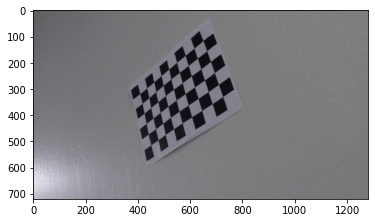

In [3]:
# We can iterate through this list to see some of our calbiration images
for cal_image in cal_images[:5]:
    img = plt.imread('camera_cal/' + cal_image)
    plt.imshow(img)
    plt.show()

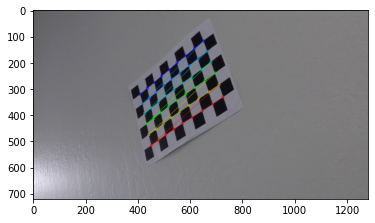

In [4]:
# Set the correct number of inside and outside corners for the chessboard
nx = 9
ny = 6

# First we will test the functionality on one image
# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)

In [5]:
# We can see that the function found the corners.
# Now we can use a mixture of code examples from the lesson material and from opencv
# documentation to calibrate the camera using multiple images

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# This is done on an arbitrary scale, and the Z values are all zero because we are
# treating the plane of the checkerboard as the Z plane of the 3D coordinate frame
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
# A look at the output
objp[:5]

array([[0., 0., 0.],
       [1., 0., 0.],
       [2., 0., 0.],
       [3., 0., 0.],
       [4., 0., 0.]], dtype=float32)

In [6]:
# The code below is taken from OpenCV's Camera Calibration documentation (slightly modified)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# List for images where corners are not found
unsuccessful = []

# termination criteria for corner refinement
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

for cal_image in cal_images:
    # Note that we're using plt.imread() so we use RGB2GRAY color conversion
    img = plt.imread('camera_cal/' + cal_image)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        # Stores the list we created earlier for every successful return
        objpoints.append(objp)
        corners = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(1000)
    # Report when corners are not found
    else:
        print('Corners not found for ', cal_image)
        unsuccessful.append(cal_image)
cv2.destroyAllWindows()

Corners not found for  calibration1.jpg
Corners not found for  calibration4.jpg
Corners not found for  calibration5.jpg


In [7]:
unsuccessful

['calibration1.jpg', 'calibration4.jpg', 'calibration5.jpg']

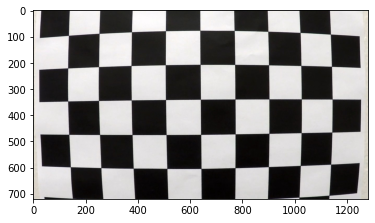

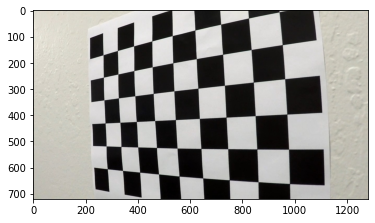

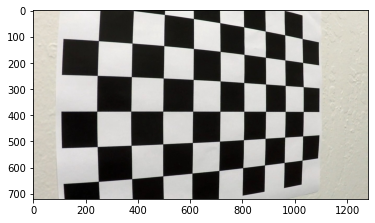

In [9]:
# We can see that 3 images did not have successful corner detection. Let's take a closer
# look at these 3 images:
for bad_img in unsuccessful:
    bad_img = plt.imread('camera_cal/' + bad_img)
    plt.imshow(bad_img)
    plt.show()

In [10]:
# We can see that two of these images have partial occlusion of the corners to be detected,
# and for the third it is very close. We should be able to get by with the data that we got
# using 17 photos, however, so we will not deal with these occluded pictures (although we
# could by modifying the objp lists used in the process)

In [11]:
# Now to extract the camera matrix from our corner detections
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                                   imgpoints, 
                                                   gray.shape[::-1], None, None)

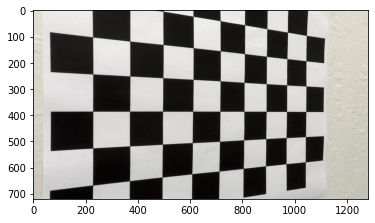

In [12]:
# Now we can run one of our bad images through this and see if it is fixed
undist = cv2.undistort(bad_img, mtx, dist, None, mtx)
plt.imshow(undist);

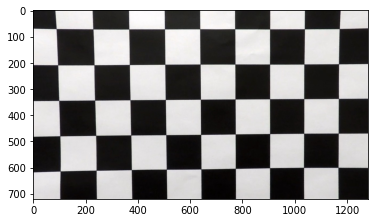

In [13]:
# This looks quite good. Let's test it on the other partially occluded chessboard image
bad_img = plt.imread('camera_cal/' + unsuccessful[0])
undist = cv2.undistort(bad_img, mtx, dist, None, mtx)
plt.imshow(undist);

In [14]:
# These look good, our camera matrix looks satisfactory, and we can move on. Let's look at the
# resulting camera matrix and distortion coefficients we have obtained
np.set_printoptions(suppress=True)
print('Camera Matrix:')
print(mtx.round(3), '\n')
print('Distortion Coefficients:')
print(dist.round(3))

Camera Matrix:
[[1156.94     0.     665.949]
 [   0.    1152.139  388.785]
 [   0.       0.       1.   ]] 

Distortion Coefficients:
[[-0.238 -0.085 -0.001 -0.     0.106]]


<a id='perspective_trans'></a>
## Perspective Transformation
Now that we have our camera calibration done, we need to figure out the perspective transformation we will use for each image to make the lines vertical so that we can fit polynomial curves to them. We can use images with straight lane lines to find the right source and destination points. Two such images have been provided in the test_images/ folder.

In [15]:
test_images = os.listdir('test_images/')
test_images[:5]

['straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg']

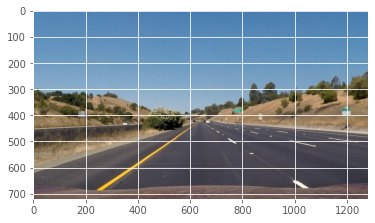

In [16]:
# We can use a plt style with a grid to get a good idea of the source points we want to use
plt.style.use('ggplot')
straight_img1 = plt.imread('test_images/' + test_images[0])
# Undistort the image
undist = cv2.undistort(straight_img1, mtx, dist, None, mtx)
plt.imshow(straight_img1);

[[[ 200  720]]

 [[ 620  425]]

 [[ 650  425]]

 [[1110  720]]]


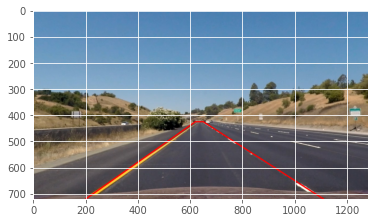

In [17]:
# looks like the line goes down intersect the x axis at 200 and 1100, and goes up to around
# (620, 425) and (625, 425)
# We can draw a rectangle to check these estimates
imheight, imwidth = undist.shape[0], undist.shape[1]
pts = np.array([[200, imheight], [620, 425],
                [650, 425], [1110, imheight]],
               np.int32)
  
pts = pts.reshape((-1, 1, 2))
print(pts)
rect = cv2.polylines(undist, [pts], False, (255, 0, 0), thickness=4)
plt.imshow(rect);

In [22]:
# We now have our source points. The destination points can be drawn straight up from the bottom
# of the image.
dst = np.array([[200, imheight], [200, 0],
                [1110, 0], [1110, imheight]],
               np.float32)
#dst = dst.reshape((-1, 1, 2))
src = np.array([[200, imheight], [620, 425],
                [650, 425], [1110, imheight]],
               np.float32)

M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(undist, M, (imwidth, imheight), flags=cv2.INTER_LINEAR)

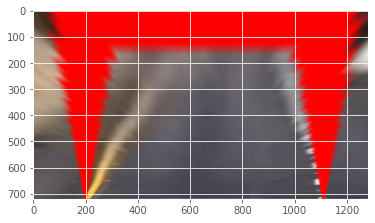

In [23]:
plt.imshow(warped);

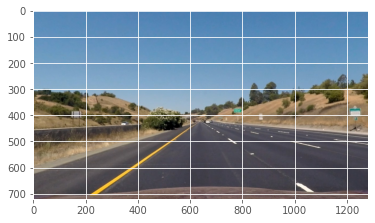

In [68]:
# We can see a couple of things here. First is that the lane horizon chosen is probably too
# far away, because the image is becoming very distorted at the top. Second, we can see that
# the red lines have been drawn on the image that we passed through the polylines function,
# so we will want to use a copy in the future, but in this case it's ok because it has shown us
# that while the red lines have been made vertical, the lane lines didn't exactly follow, and
# are inside of the red lines as we get further down the lanes, so we need to correct our source
# point selection

# First let's get a clean copy of the undistorted image, and try and pick some better points
undist = cv2.undistort(straight_img1, mtx, dist, None, mtx)
plt.imshow(undist);

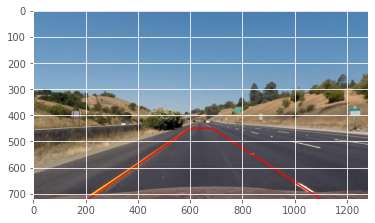

In [69]:
# Let's bring a closer lane horizon
imheight, imwidth = undist.shape[0], undist.shape[1]
pts = np.array([[210, imheight], [600, 450],
                [685, 450], [1100, imheight]],
               np.int32)
  
pts = pts.reshape((-1, 1, 2))
rect = cv2.polylines(undist.copy(), [pts], False, (255, 0, 0), thickness=4)
plt.imshow(rect);

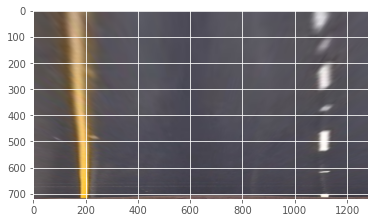

In [70]:
# This trapezoid looks better, let's try this for a transform.
dst = np.array([[200, imheight], [200, 0],
                [1110, 0], [1110, imheight]],
               np.float32)

src = np.array([[210, imheight], [600, 450],
                [685, 450], [1100, imheight]],
               np.float32)

M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(undist.copy(), M, (imwidth, imheight), flags=cv2.INTER_LINEAR)

plt.imshow(warped)

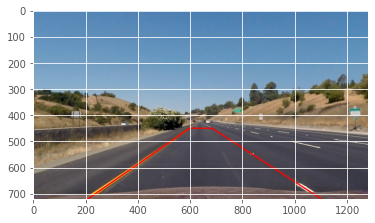

In [71]:
# This looks a lot better, let's fine tune it another time
pts = np.array([[208, imheight], [598, 450],
                [684, 450], [1102, imheight]],
               np.int32)
  
pts = pts.reshape((-1, 1, 2))
rect = cv2.polylines(undist.copy(), [pts], False, (255, 0, 0), thickness=4)
plt.imshow(rect);

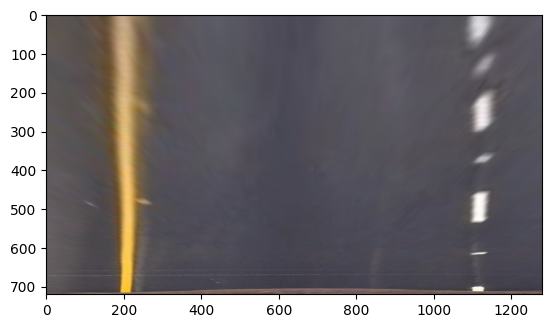

In [140]:
# Now for the transform
dst = np.array([[200, imheight], [200, 0],
                [1110, 0], [1110, imheight]],
               np.float32)

src = np.array([[200, imheight], [596, 450],
                [683, 450], [1100, imheight]],
               np.float32)

M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(undist.copy(), M, (imwidth, imheight), flags=cv2.INTER_LINEAR)

plt.imshow(warped)

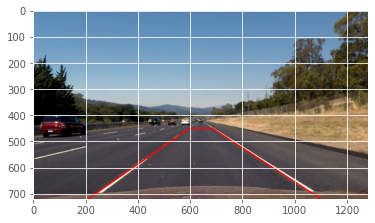

In [73]:
# This looks pretty good. It's likely the lane was not PERFECTLY straight, so there's a little
# wobble, but we've got it as good as it can look. Let's try this transform on the other
# straight line test image to see if it works there as well, and if so, we can move on
straight_img2 = plt.imread('test_images/' + test_images[1])
# Undistort the image
undist2 = cv2.undistort(straight_img2, mtx, dist, None, mtx)
pts = np.array([[208, imheight], [598, 450],
                [684, 450], [1102, imheight]],
               np.int32)
  
pts = pts.reshape((-1, 1, 2))
rect = cv2.polylines(undist2.copy(), [pts], False, (255, 0, 0), thickness=4)
plt.imshow(rect);

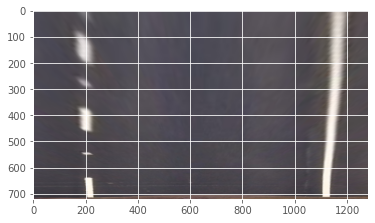

In [74]:
## This looks pretty good on the image, let's see what the transform looks like
dst = np.array([[200, imheight], [200, 0],
                [1110, 0], [1110, imheight]],
               np.float32)

src = np.array([[200, imheight], [596, 450],
                [683, 450], [1100, imheight]],
               np.float32)

M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(undist2.copy(), M, (imwidth, imheight), flags=cv2.INTER_LINEAR)

plt.imshow(warped)

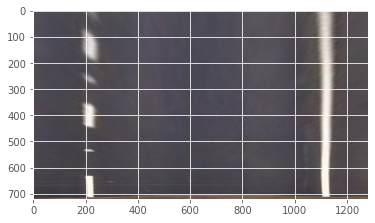

In [79]:
# We can see that these have not come out exactly parallel, the right hand line is bending
# outward, and the left side is a bit too. We could widen the top of the trapezoid a bit, and
# backtest it on the other image.
dst = np.array([[200, imheight], [200, 0],
                [1110, 0], [1110, imheight]],
               np.float32)

src = np.array([[200, imheight], [593, 450],
                [688, 450], [1100, imheight]],
               np.float32)

M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(undist2.copy(), M, (imwidth, imheight), flags=cv2.INTER_LINEAR)

plt.imshow(warped)

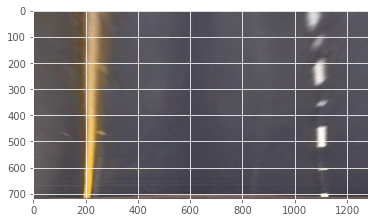

In [80]:
# This looks good for this image, let's see what it does to the first one
warped = cv2.warpPerspective(undist.copy(), M, (imwidth, imheight), flags=cv2.INTER_LINEAR)

plt.imshow(warped)

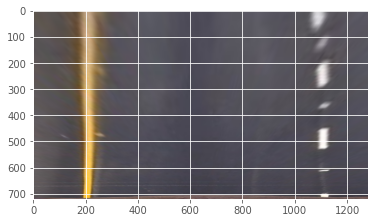

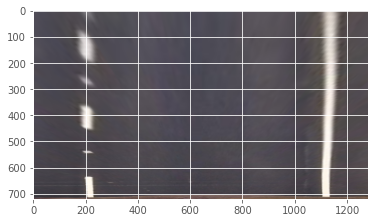

In [81]:
# As one would expect, we've made these lane lines taper inward. Obviously the road plane is
# not completely flat in these images, and/or there is a difference in camera perspective.
# We'll just split the difference and move on.
dst = np.array([[200, imheight], [200, 0],
                [1110, 0], [1110, imheight]],
               np.float32)

src = np.array([[200, imheight], [595, 450],
                [686, 450], [1100, imheight]],
               np.float32)

M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(undist.copy(), M, (imwidth, imheight), flags=cv2.INTER_LINEAR)
warped2 = cv2.warpPerspective(undist2.copy(), M, (imwidth, imheight), flags=cv2.INTER_LINEAR)

plt.imshow(warped)
plt.show()
plt.imshow(warped2)
plt.show()

In [ ]:
# This is satisfactory. We'll use this transformation for the project.

<a id='color_grad_thresh'></a>
## Color and Gradient Thresholding
Now that we've settled on a perspective transformation, we need to find a color and gradient threshold choice which gives us consistently defined lane lines.

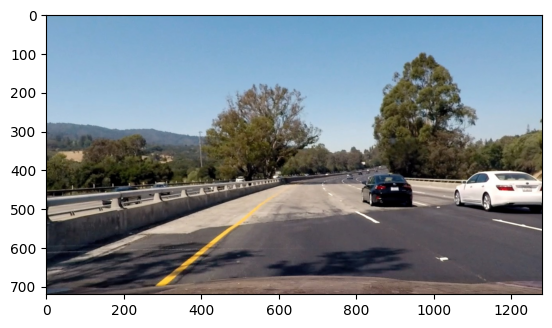

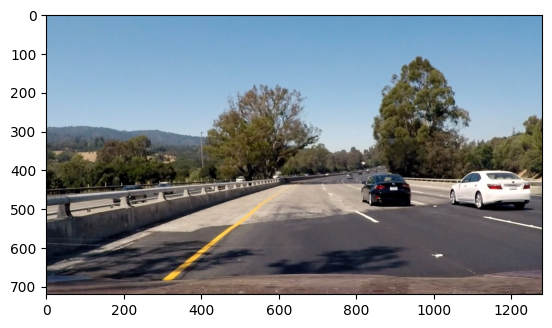

In [133]:
# First, let's pull up two particularly challenging image with a lot of pavement color changes
# and shadows.
hard_img1 = plt.imread('test_images/test1.jpg')
hard_img1 = cv2.undistort(hard_img1, mtx, dist, None, mtx)
hard_img2 = plt.imread('test_images/test4.jpg')
hard_img1 = cv2.undistort(hard_img2, mtx, dist, None, mtx)

# We can also take off the grid
plt.rcdefaults()

# And let's see these images raw for comparison to our results
plt.imshow(hard_img1)
plt.show()
plt.imshow(hard_img2)
plt.show()

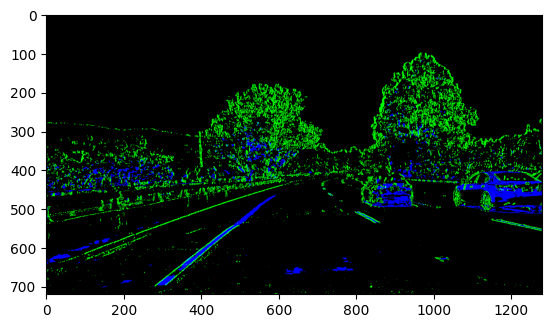

In [134]:
# I'll include a boolean flag 'diagnostic' to switch between whether this function returns
# a full binary image or a RGB image we can use to modify parameters
def binary_lane_img(image, s_thresh=(150, 255), sx_thresh=(20, 100), diagnostic=False):
    # Copy image to preserve input
    img = np.copy(image)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    if diagnostic:
        # Stack each channel
        color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
        return color_binary
    else:
        binary = np.zeros_like(img[:, :, 0])
        binary[(sxbinary == 1) | (s_binary == 1)] = 1
        return binary
    
result = binary_lane_img(hard_img1, diagnostic=True)
plt.imshow(result);

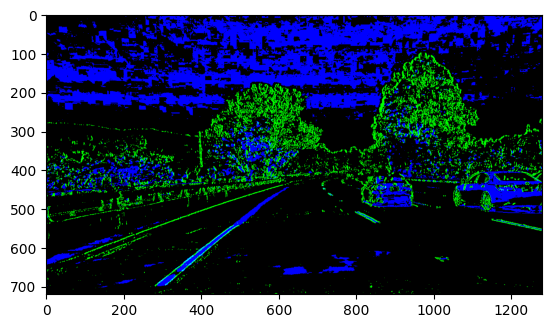

In [135]:
# The right lane line is coming through, but the left line is ending a little earlier than what
# is visually discernable in the raw image, let's try again with different params
result = binary_lane_img(hard_img1, s_thresh=(120, 255), sx_thresh=(20, 100), diagnostic=True)
plt.imshow(result);

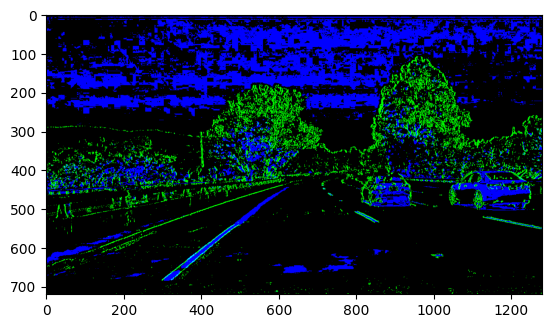

In [136]:
# We're getting more of the left line now, just about as much as you can see with the naked
# eye in the picture. We've also brought the sky in, but that won't affect our results in once
# we do the transform, so this is fine. Let's see what these params look like on the second
# hard image
result = binary_lane_img(hard_img2, s_thresh=(120, 255), sx_thresh=(20, 100), diagnostic=True)
plt.imshow(result);

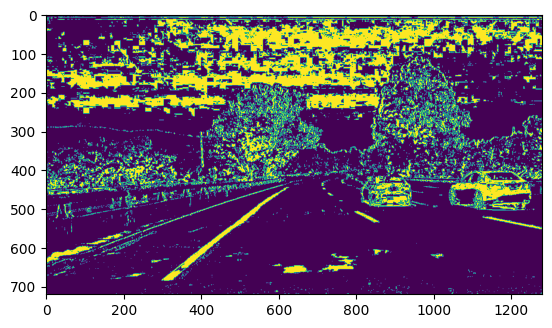

In [137]:
# This looks like it will probably work for our purposes. Let's see the binary output
result = binary_lane_img(hard_img2, s_thresh=(120, 255), sx_thresh=(20, 100), diagnostic=False)
plt.imshow(result);

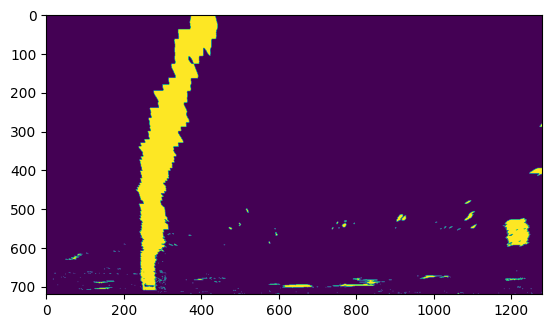

In [144]:
# And now to see the warped version
binary_warped = cv2.warpPerspective(result.copy(), 
                                    M, 
                                    (imwidth, imheight), 
                                    flags=cv2.INTER_LINEAR)
plt.imshow(binary_warped);

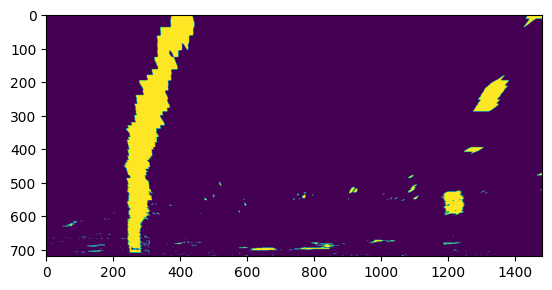

In [145]:
# We can see that the right lane line goes off the screen, but it still may be enough to fit
# a polynomial curve to, or else possibly just have this frame be skipped. We'll cross that
# bridge (no pun intended) when we come to it.
# It should be noted that we can actually return a larger image to include the rest of the
# line, and this may end up being part of the solution:
binary_warped = cv2.warpPerspective(result.copy(), 
                                    M, 
                                    (imwidth + 200, imheight), 
                                    flags=cv2.INTER_LINEAR)
plt.imshow(binary_warped);

<a id='fit_poly'></a>
## Fitting Polynomial Curves
Now that we can produce warped binary images, we need to fit polynomial curves to them.

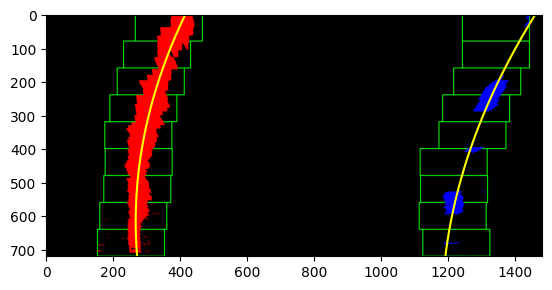

In [146]:
# On a first iteration, we need to use a sliding window search
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        if len(good_left_inds) > minpix:
            leftx_current = np.mean(nonzerox[good_left_inds]).astype('int')
        if len(good_right_inds) > minpix:
            rightx_current = np.mean(nonzerox[good_right_inds]).astype('int')
        ### (`right` or `leftx_current`) on their mean position ###
        #pass # Remove this when you add your function

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


out_img = fit_polynomial(binary_warped)

plt.imshow(out_img)

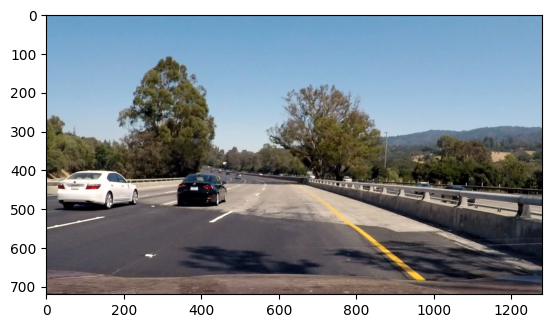

In [147]:
# We can see that this has worked well, and we have captured the curvature of the right lane
# by expanding the image size. This leads us to another important consideration, which is what
# would happen if the lane curved to the left? We can simulate this by flipping the image
# around
hard_img2_flipped = hard_img2[:, ::-1].copy()
plt.imshow(hard_img2_flipped);

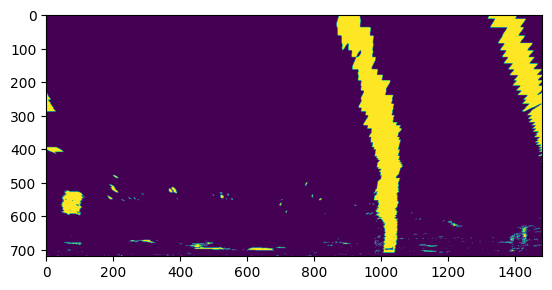

In [148]:
# Now let's see what our warped binary image would look like
result = binary_lane_img(hard_img2_flipped, 
                         s_thresh=(120, 255), 
                         sx_thresh=(20, 100), 
                         diagnostic=False)

binary_warped = cv2.warpPerspective(result.copy(), 
                                    M, 
                                    (imwidth + 200, imheight), 
                                    flags=cv2.INTER_LINEAR)
plt.imshow(binary_warped);

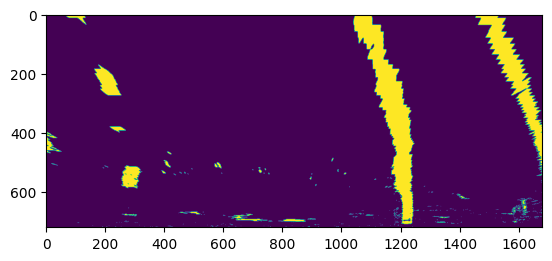

In [149]:
# As expected, the left lane now disappears off the left side of the image. If we are going
# to be adding a buffer to the right side of the image, we should do the same to the left side.
# We will need to modify our perspective transformation to accomodate this by adding 200 pixels
# to our destination points. This will ultimately be reversible, so it should be ok

# We should define a variable called padding to accomodate for this adjustment
padding = 200

dst = np.array([[200 + padding, imheight], [200 + padding, 0],
                [1110 + padding, 0], [1110 + padding, imheight]],
               np.float32)

src = np.array([[200, imheight], [593, 450],
                [688, 450], [1100, imheight]],
               np.float32)

M = cv2.getPerspectiveTransform(src, dst)
binary_warped = cv2.warpPerspective(result.copy(), 
                                    M, 
                                    (imwidth + padding * 2, imheight), 
                                    flags=cv2.INTER_LINEAR)
plt.imshow(binary_warped);

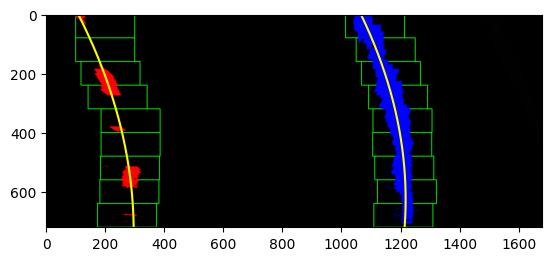

In [150]:
# Now we have enough room to work with. Let's fit the polynomial curves again
out_img = fit_polynomial(binary_warped)

plt.imshow(out_img)

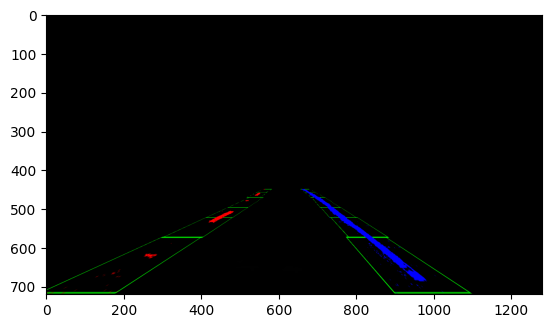

In [151]:
# This is working. Let's now see what the inverse transformation process looks like
Minv = cv2.getPerspectiveTransform(dst, src)

reverse_warped = cv2.warpPerspective(out_img.copy(), 
                                    Minv, 
                                    (imwidth, imheight), 
                                    flags=cv2.INTER_LINEAR)
plt.imshow(reverse_warped);

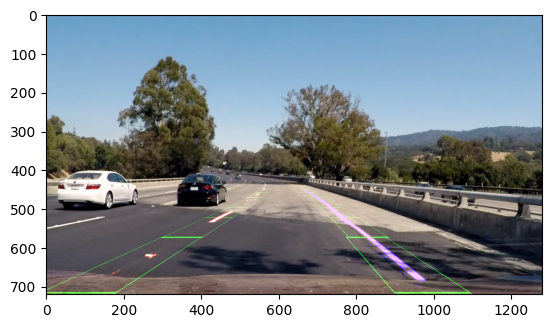

In [155]:
result = cv2.addWeighted(hard_img2_flipped, 1, reverse_warped, 1, 0)
plt.imshow(result);

In [156]:
# Looks like we're in business. It's time to make this pipeline into a class object. We'll work
# on shading in the lane green and finding the vehicle's position relative to lane center in
# that process.

## The Full Pipeline Class
Now that we have worked out all of the necessary mechanics for advanced lane finding, it is time to put all of this into a clean class object, which we will ultimately apply to our test images and video.

In [160]:
mtx

array([[1156.9404652 ,    0.        ,  665.94882053],
       [   0.        , 1152.1388011 ,  388.78478769],
       [   0.        ,    0.        ,    1.        ]])

In [161]:
import glob

In [203]:
class Lane_Finder:
    """
    This class can find the lanes on the road, as well as their curvature, and locate the
    position of the car relative to the lane center. The process_image() method will take in
    an image (from the same camera used for calibration) and return an annotated image.
    
    NOTE: You may pass mtx, dist, src, and dst into the initialization explicitly or not.
    If mtx and dst are not passed, images in the calib_dir will automatically be used to
    calibrate the camera upon instantiation.
    If src/dst not provided, default parameters for perspective transformation will be used.
    """
    def __init__(self,
                 mtx=None, 
                 dist=None, 
                 calib_dir='camera_cal/',
                 src=None,
                 dst=None,
                 s_thresh=(120, 255), 
                 sx_thresh=(20, 100),
                 padding=200,
                 lane_length=30.0,
                 lane_width=3.7
                ):
        """
        Params:
        mtx - (array) intrinsic matrix for camera. Automatically generated if None
        dist - (array) distortion coefficients for camera. Auto generated if None
        calib_dir - (str) directory to camera calibration images. Only used if above are None
                    NOTE: only calibration images should be stored in this folder!
        src - (array) source points for perspective transform
        dst - (array) destination points for perspective transform
        s_thresh - (tuple) lower and upper threshold for saturation
        sx_thresh - (tuple) lower and upper threshold for x gradient
        padding - (int) number of pixels to add on sides of warped image to catch lane curvature
        lane_length - (float) number of meters (est) of lane in front of car being considered
        lane_width - (float) width of lane in meters
        """
        self.s_thresh = s_thresh
        self.sx_thresh = sx_thresh
        self.padding = padding
        self.lane_length = lane_length
        self.lane_width = lane_width
        # Try to calibrate camera if calibration information not provided
        if mtx is None or dst is None:
            print('Calibrating camera with images in {}'.format(calib_dir))
            try:
                self.calibrate(calib_dir)
                self.calibrated = True
            except:
                print('Failed to calibrate camera, using no image correction.')
                print('Consider retrying calibration with appropriate calib_dir')
                self.calibrated = False
        
        # Load default src and dst points if none provided:
        if src == None:
            print('here')
            src = np.array([[200, imheight], [595, 450],
                            [686, 450], [1100, imheight]],
                           np.float32)
        if dst == None:
            dst = np.array([[200 + padding, imheight], [200 + padding, 0],
                            [1110 + padding, 0], [1110 + padding, imheight]],
                           np.float32)
    
        # Set up transformation matrix and inverse transform matrix
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.Minv = cv2.getPerspectiveTransform(dst, src)
                
    def calibrate(self, calib_dir):
        """
        Calibrates camera based on chessboard images in provided directory.
        """
        cal_images = os.listdir(calib_dir)
        objpoints = [] # 3d point in real world space
        imgpoints = [] # 2d points in image plane.

        # termination criteria for corner refinement
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

        for cal_image in cal_images:
            # Note that we're using plt.imread() so we use RGB2GRAY color conversion
            img = plt.imread('camera_cal/' + cal_image)
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            # Find the chess board corners
            ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
            # If found, add object points, image points (after refining them)
            if ret == True:
                # Stores the list we created earlier for every successful return
                objpoints.append(objp)
                corners = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
                imgpoints.append(corners)
                # Draw and display the corners
                cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
                cv2.imshow('img', img)
                cv2.waitKey(200)
            # Report when corners are not found
            else:
                print('Corners not found for ', cal_image)
        cv2.destroyAllWindows()
        
        # Now to extract the camera matrix from our corner detections
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                                           imgpoints, 
                                                           gray.shape[::-1], None, None)
        # Apply the calibration
        self.mtx = mtx
        self.dist = dist
        print('Calibration successful!')
        
        pass
    
    def binary_lane_img(self, 
                        image, 
                        s_thresh=None, 
                        sx_thresh=None, 
                        diagnostic=False):
        if s_thresh == None:
            s_thresh = self.s_thresh
        if sx_thresh == None:
            sx_thresh = self.sx_thresh
        # Copy image to preserve input
        img = np.copy(image)
        # Convert to HLS color space and separate the V channel
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
        # Sobel x
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

        # Threshold color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

        if diagnostic:
            # Stack each channel
            color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
            return color_binary
        else:
            binary = np.zeros_like(img[:, :, 0])
            binary[(sxbinary == 1) | (s_binary == 1)] = 1
            return binary
        
        
    # On a first iteration, we need to use a sliding window search
    def find_lane_pixels(self, binary_warped):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        # Establish meters per pixel in x direction
        self.xm_per_pixel = self.lane_width / (rightx_base - leftx_base)

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            ### Find the four below boundaries of the window ###
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            ## Draw the windows on the visualization image
            #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            #(win_xleft_high,win_y_high),(0,255,0), 2) 
            #cv2.rectangle(out_img,(win_xright_low,win_y_low),
            #(win_xright_high,win_y_high),(0,255,0), 2) 

            ### Identify the nonzero pixels in x and y within the window ###
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
            (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            ### If you found > minpix pixels, recenter next window ###
            if len(good_left_inds) > minpix:
                leftx_current = np.mean(nonzerox[good_left_inds]).astype('int')
            if len(good_right_inds) > minpix:
                rightx_current = np.mean(nonzerox[good_right_inds]).astype('int')
            ### (`right` or `leftx_current`) on their mean position ###
            #pass # Remove this when you add your function

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty, out_img
    
    
    def search_around_poly(self, binary_warped):

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Set the area of search based on activated x-values
        # within the +/- margin of our polynomial function
        prev_line_left = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2]
        prev_line_right = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2]
        left_lane_inds = ((nonzerox >= prev_line_left - margin) &
                          (nonzerox < prev_line_left + margin)).nonzero()[0]
        right_lane_inds = ((nonzerox >= prev_line_right - margin) &
                           (nonzerox < prev_line_right + margin)).nonzero()[0]

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit new polynomials
        left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        ## End visualization steps ##

        return result


    def fit_polynomial(self, leftx, lefty, rightx, righty):
        # Fit a second order polynomial to each using np.polyfit()
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        self.left_fit_metric = np.polyfit(lefty * self.ym_per_pixel,
                                          leftx * self.xm_per_pixel,
                                          2
                                         )
        self.right_fit_metric = np.polyfit(righty * self.ym_per_pixel,
                                           rightx * self.xm_per_pixel,
                                           2
                                          )
        pass
    
    
    def calc_curvature(self, y_eval):
        left_curverad = (1 + (2*self.left_fit_metric[0]*y_eval + \
                              self.left_fit_metric[1])**2)**(3/2) / \
                            np.abs(2*self.left_fit_metric[0])
        right_curverad = (1 + (2*self.right_fit_metric[0]*y_eval + \
                               self.right_fit_metric[1])**2)**(3/2) / \
                            np.abs(2*self.right_fit_metric[0])
        # Return curve radii
        return left_curverad, right_curverad
    
    
    def process_image(self, image):
        imheight = image.shape[0]
        imwidth = image.shape[1]
        # Get binary image
        binary = self.binary_lane_img(image)
        # Warp binary image
        binary_warped = cv2.warpPerspective(binary.copy(), 
                                            self.M, 
                                            (imwidth + self.padding * 2, imheight), 
                                            flags=cv2.INTER_LINEAR)
        # Establish meters per pixel in y direction
        self.ym_per_pixel = self.lane_length / binary_warped.shape[0]
        # Find our lane pixels first
        leftx, lefty, rightx, righty, out_img = self.find_lane_pixels(binary_warped)
        # Fit polynomials
        self.fit_polynomial(leftx, lefty, rightx, righty)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        # Calculate curvature
        y_eval = np.max(ploty)
        left_curverad, right_curverad = self.calc_curvature(y_eval)
        # Get average curve radius
        curverad = (left_curverad + right_curverad) / 2
        try:
            left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
            right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty

        ## Visualization ##    
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(out_img, np.int_([pts]), (0,255, 0))
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(out_img, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        out_img = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        # Write lane curvature on image
        font_face = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        curve_string = 'Lane Curvature Radius: {}m'.format(round(curverad, 2))
        out_img = cv2.putText(out_img, 
                              curve_string, 
                              (25,50),
                              font_face,
                              font_scale,
                              (255, 255, 255),
                              thickness=3
                             )
        # Plots the left and right polynomials on the lane lines
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')

        return out_img

In [204]:
lanefinder = Lane_Finder()

Calibrating camera with images in camera_cal/
Corners not found for  calibration1.jpg
Corners not found for  calibration4.jpg
Corners not found for  calibration5.jpg
Calibration successful!
here


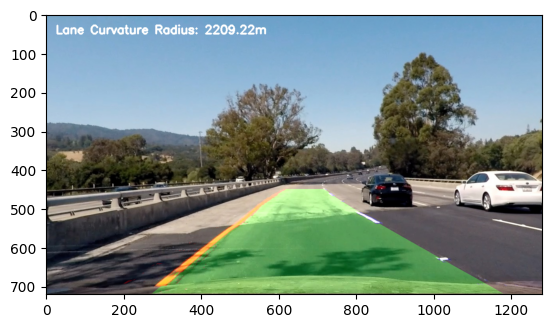

In [205]:
output = lanefinder.process_image(hard_img1)
plt.imshow(output);

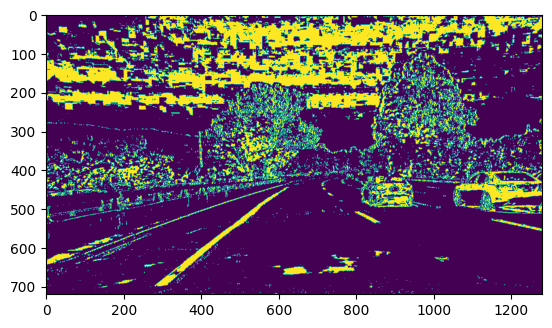

In [206]:
plt.imshow(lanefinder.binary_lane_img(hard_img1))